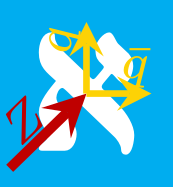

# Number of $\pi^0$s in $Z\rightarrow q\bar{q}$ events

In this notebook we will investigate $Z\rightarrow q\bar{q}$ event for the number of $\pi^0$s produced. 

Neutral pions cannot directly be detected in the ALEPH experiment ($\aleph$).  Instead, we have to look for they decay products.  The typical  $\pi^0$ chain is 

$$\pi^0\rightarrow\gamma\gamma\quad.$$ 

The photons ($\gamma$) can be detected in the ALEPH electromagnetic calorimeter.  Thus, if we know the momentum $\vec{p}$ of these photons, we can form all possible pair combinations of photons and calculate the _invariant mass_ of these combinations as 

$$m_{\mathrm{inv}} = \sqrt{\left(p_1+p_2)^2 - p^2\right)}\quad,$$ 

where 

\begin{align*}
  \vec{p}_1 &= \left(p_{1x},p_{1y},p_{1z}\right) & \text{First photon momentum}\\
  \vec{p}_2 &= \left(p_{2x},p_{2y},p_{2z}\right) & \text{Second photon momentum}\\
  p_1 &= |\vec{p}_1| = \sqrt{p_{1x}^2+p_{1y}^2+p_{1z}^2}\\
  p_2 &= |\vec{p}_2| = \sqrt{p_{2x}^2+p_{2y}^2+p_{2z}^2}\\
  \vec{p} &= \vec{p}_1 + \vec{p}_2 = \left(p_{x1}+p_{x2},p_{y1}+p_{y2},p_{z1}+p_{z2}\right)\\
  p &= |\vec{p}| = \sqrt{(p_{x1}+p_{x2})^2+(p_{y1}+p_{y2})^2+(p_{z1}+p_{z2})^2} & .\\
\end{align*}

This is done in the class `GammaGamma` (in [`gammagamma.py`](../pyzqq/gammagamma.py)). 

Of course, when we form all possible combinations of pairs of photons, we will _also_ make combinations that _do not_ correspond to $\pi^0$ decays. Some are from $\eta$ decays, see [FitGGEta](FitGGEta.ipynb), others have no relation to each other.  This _background_ is therefore labelled the _combinatorial_ background, and it will be present in the distribution $m_{\mathrm{inv}}$. 

In this notebook, we will take the invariant mass spectra ($\mathrm{d}N/\mathrm{d}m_{\mathrm{inv}}$) from real _and_ simulated events.  We will try to estimate the number of $\pi^0$s (per $Z\rightarrow q\bar{q}$ event) by fitting a model function to ($\mathrm{d}N/\mathrm{d}m_{\mathrm{inv}}$).  This model will contain _background_ and _signal_ parts which should capture the combinatorial background and the $\pi^0$ invariant mass. 

## Set-up

Before we go on to our analysis, we need to set up a few things. 

First, we modify the load path to allow loading of `pyzqq` code. 

In [1]:
from sys import path 
path.append('..')

We then load a utility to read in the data.  

In [2]:
from pyzqq.utils import loadResults

Use the _MatPlotLib_ Notebook interface

In [3]:
%matplotlib notebook

## The data

Now that we have that utility in place, we can use that to load in the distributions for both real and simulated data. 

In [4]:
da_data = loadResults('zqqdaall.json')
mc_data = loadResults('zqqmcall.json')

Let us plot the invariant mass spectras in those results. 

<IPython.core.display.Javascript object>


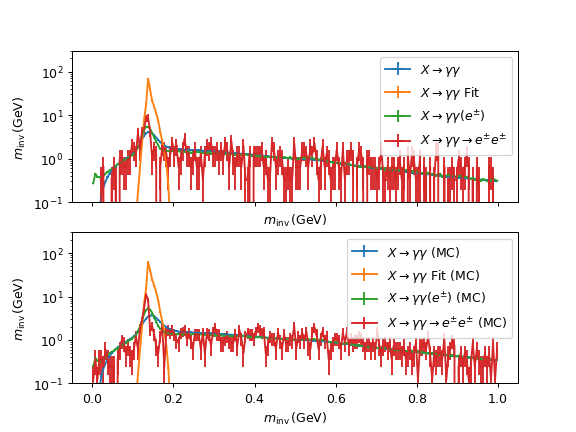

Keywords "nev" and "scale" ignored when normalising
Keywords "nev" and "scale" ignored when normalising
Keywords "nev" and "scale" ignored when normalising
Keywords "nev" and "scale" ignored when normalising
Keywords "nev" and "scale" ignored when normalising
Keywords "nev" and "scale" ignored when normalising
Keywords "nev" and "scale" ignored when normalising
Keywords "nev" and "scale" ignored when normalising


In [5]:
from matplotlib.pyplot import subplots 

fig, ax = subplots(nrows=2,sharex=True)

da_nev = da_data['gammagamma']['nev']
for name, hist in da_data['gammagamma']['inv_mass'].items():
    hist.plot(ax[0],nev=da_nev)
    
mc_nev = mc_data['gammagamma']['nev']
for name, hist in mc_data['gammagamma']['inv_mass'].items():
    hist.plot(ax[1],label=hist.title+' (MC)',nev=mc_nev)
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylim(1e-1,3e2)
ax[1].set_ylim(1e-1,3e2)
ax[0].legend()
ax[1].legend();

We only want to the $\mathrm{d}N/\mathrm{d}m_{\mathrm{inv}}$ spectra from $\gamma\gamma$ combinations at this point, so write a function that will give us those in a convinient form. 

In [6]:
def get_g_g(data):
    from numpy import all 
    nev   = data['gammagamma']['nev']
    hist  = data['gammagamma']['inv_mass']['g_g']
    graph = hist.asGraph(density=True,nev=nev)
    
    return graph


da_g_g = get_g_g(da_data)
mc_g_g = get_g_g(mc_data)

The variables `da_g_g` and `mc_g_g` are `Graph` objects which can give us correlated pairs of $m_{\mathrm{inv}}$ and  $\mathrm{d}N/\mathrm{d}m_{\mathrm{inv}}$ as well as their associated uncertainties. 

## Our model of the data

We define our model function to fit to the invariant mass spectra.  This is defined in terms of the background function 

$$f_{\mathrm{bg}}(m;N_{b},m_b,p,a,b) = N_{b}|m-m_b|^{p}e^{am+bm^2}\quad,$$ 

and a scaled, normal distribution signal function 

$$f_{\mathrm{sig}}(m;N,m_0,w) = N\frac{1}{\sqrt{2\pi}w}e^{-\frac12\left(\frac{m-m_0}{w}\right)^2}\quad,$$ 

so that our model $f$, becomes 

$$f(m;N_{b},m_b,p,a,b,N,m_0,w) = f_{\mathrm{bg}}(m;N_{b},m_b,p,a,b) + f_{\mathrm{sig}}(m;N,m_0,w)\quad.$$ 

We define our model of the background. 

In [7]:
def background(m,N,m_b,p,a,b):
    '''Background function'''
    from numpy import abs, exp
    return N * abs(m - m_b)**p * exp(a * m + b * m**2)

background.parNames = ['N_b','m_b','p','a','b']
background.p0       = [1,0,1,1,0]

We _annotated_ the function with the parameter names and initial guess of the parameters.  We will use that later when we plot the results and perform the fit.

We define the signal function utilising the normal distribution probability density function (PDF) defined in the Python package `scipy`.

In [8]:
from scipy.stats import norm

def signal(m,N,m0,w):
    return N * norm.pdf(m,loc=m0,scale=w)

signal.parNames = ['N','m_0','w']
signal.p0       = [1, 0.14, .01]

We really want to fix the parameter `m_b` to `background` above, so we define a closure that give us back a background function with fixed `m_b`. 

In [9]:
def fix_background(m_b):
    def f(m,N,p,a,b):
        return background(m,N,m_b,p,a,b)
    f.parNames = background.parNames[:1]+background.parNames[2:]
    f.p0       = background.p0      [:1]+background.p0      [2:]
    
    return f 

fixed_background = fix_background(0.025)

An alternative model for the background could be a simple polynomial 

In [10]:
def poly_background(m,a,b,c,d):
    return a + b * m + c * m**2 + d * m**3

poly_background.parNames = ['a','b','c','d']
poly_background.p0       = [0,0,0,0]

This function could be used to study the systematic effect of the background assumption. 

## Fitting the model to the data

We now want to fit our model to the data - both real and simulated data.  We want to be able to change our fit range, so we make a function that does the fit for us and also plots the result.  We also want to be able to change background models, so we make the background model function a parameter of the function.  Inside the function, we define the actual full model as 

$$f = f_{\mathrm{signal}}+f_{\mathrm{background}}\quad.$$
 
**NB** Here we use the Python package [`nbi_stat`](https://cholmcc.gitlab.io/nbi-python/statistics/#Statistik).  If you do not have that package, you can install it by executing 

    pip install nbi_stat 
    
The package is heavily [documented](https://cholmcc.gitlab.io/nbi-python/statistics/nbi_stat/) and all is explained in the free (as in beer _and_ speech) book [Statistics Overview - With Python](https://cholmcc.gitlab.io/nbi-python/statistics/#Statistik).  

In [11]:
def fit_pi0(graph,low,high,bg,ax,which):
    from numpy import asarray
    from nbi_stat import fit, fit_plot, chi2nu
    
    mask   = graph.mask(low,high)
    x      = graph.x[mask]
    y      = graph.y[mask]
    ey     = graph.ey[mask]
    p0     = bg.p0 + signal.p0 
    pN     = bg.parNames + signal.parNames 
    nbg    = len(bg.p0)
    
    
    def model(m,*p):
        return bg(m,*p[:nbg])+signal(m,*p[nbg:])
    
    p, cov = fit(model, x, y, p0, ey)

    chi2,nu = chi2nu(x, y, model, p, ey)
    fit_plot(graph.x, graph.y, graph.ey,
             model, p, cov,
             parameters=pN,
             data={'fmt':'o','label':which,'markersize':3},
             fit={'label':'Fit'},
             xeval=x,
             chi2=chi2,
             axes=ax)
    bg = ax.plot(x,bg(x,*p[:nbg]),'--',label='Background')
    
    ax.set_xlabel(graph.xLabel)
    ax.set_ylabel(graph.yLabel)
    ax.legend(loc='upper center')
    
    return p, cov

We now create a plot with both the real and simulated data and fit our model to both.  The plot will show 

- the data (simulated or real),
- the best fit of the model to the data (including error bands),
- the background component of the model, 
- and information about the fit 

<IPython.core.display.Javascript object>


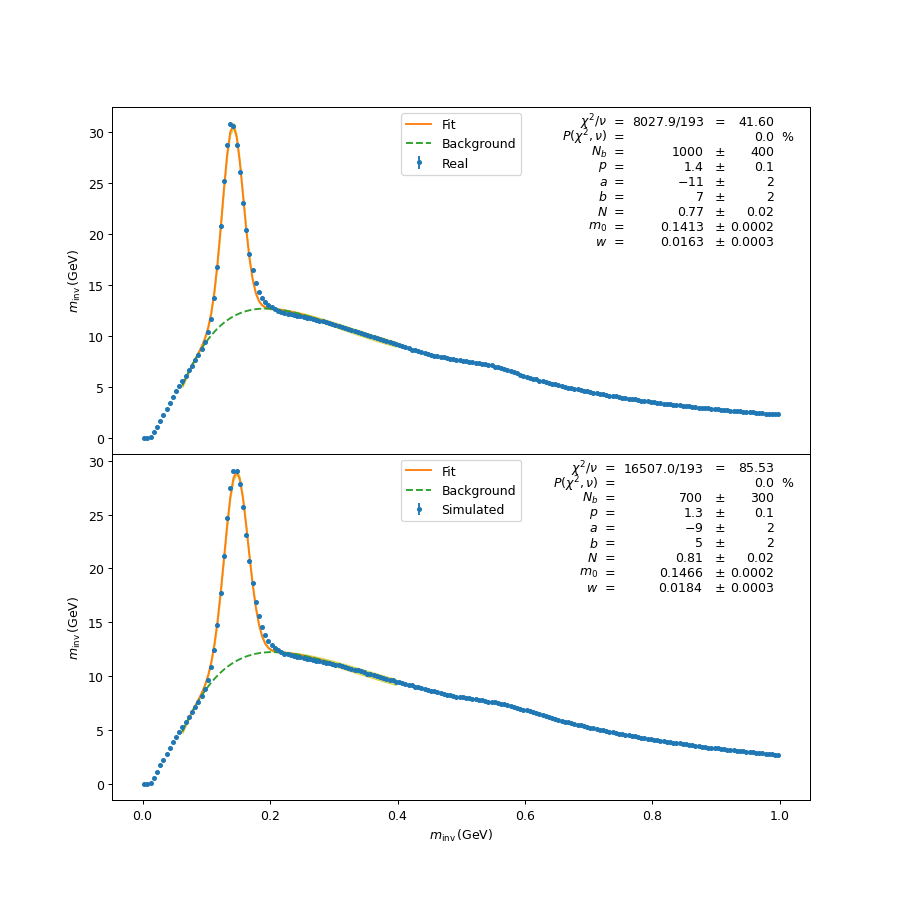

In [12]:
fig, ax = subplots(nrows=2,sharex=True,gridspec_kw={'hspace':0},figsize=(10,10))

da_p, da_cov = fit_pi0(da_g_g,0.06,0.4,fixed_background,ax[0],'Real')
mc_p, mc_cov = fit_pi0(mc_g_g,0.06,0.4,fixed_background,ax[1],'Simulated')


The top panel shows the invariant mass spectrum from real data and the fit we performed, and the lower panel shows the same but for simulated data. 

We get the number of $\pi^0$s from the fit parameters $N$, including their uncertainty, because we define our signal function as a scaled (by $N$) normal distribution.  The scale is simply the integral of the signal.  

The square-uncertainties (or variances) of the best fit parameters is given by the diagonal of the covariance matrix $C$ from the fit.  Thus, we can obtain the uncertainty $\delta_i$ on the parameter $p_i$ by 

$$\delta_i = \sqrt{C_{ii}}\quad.$$

In [13]:
from IPython.display import Latex
from nbi_stat import format_result
from numpy import sqrt, diagonal

da_n = da_p[4]
da_e = sqrt(diagonal(da_cov)[4])
mc_n = mc_p[4]
mc_e = sqrt(diagonal(mc_cov)[4])
display(Latex(fr'$N^{{\mathrm{{real}}}}_{{\pi^0}}={format_result(da_n,da_e)}$'))
display(Latex(fr'$N^{{\mathrm{{sim}}}}_{{\pi^0}}={format_result(mc_n,mc_e)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**NB**: We used the function `format_result` from `nbi_stat` to round our uncertainty to one significant digit and then give the value with the same precision.  Generally, we should give the least uncertainty with no more than one significant digit and then report the value, and other uncertainties, to the same precision. 

## Yield of $\pi^0$s

To calculate the final yield of $\pi^0$s in $h\rightarrow q\bar{q}$ decays, we must use the generated number of $\pi^0$s per $h$ decay. 

In [14]:
eg_n = 9.4395685
eg_e  = 0.00097157442

display(Latex(fr'$N^{{\mathrm{{gen}}}}_{{\pi^0}}={format_result(eg_n,eg_e)}$'))

<IPython.core.display.Latex object>

We will then calculate the yeild as 

$$N_{\pi^{0}} = \frac{N_{\pi^0}^{\mathrm{gen}}}{N_{\pi^0}^{\mathrm{sim}}}N_{\pi^0}^{\mathrm{real}}\quad,$$

where $N^{\mathrm{real}}$ and $N^{\mathrm{sim}}$ where determined in our above fits. We get, including propagation of uncertainties, 

In [15]:
from nbi_stat import propagate_uncertainty

f  = lambda p: p[0] / p[1] * p[2]
ns = [da_n,mc_n,eg_n]
es = [da_e,mc_e,eg_e]
n  = f(ns)
e  = sqrt(propagate_uncertainty(f,ns,es))
display(Latex(fr'$N_{{\pi^0}}={format_result(n,e)}$'))

<IPython.core.display.Latex object>

**NB**: We used the function `propagate_uncertainty` from `nbi_stat` to propagate the uncertainties through on the expression for $N_{\pi^0}$ (encoded in the $\lambda$ `f` above).

The end